# Evaluate all embeddings generated with parameter_search

In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import datetime
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from evaluation_functions import nn, sil

In [3]:
wd = os.getcwd()

DF = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed", "df_focal_reduced.pkl")

OUT_COORDS = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "interim", "parameter_search", "grid_search")
OUT_EVALS = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "interim", "parameter_search", "grid_search_evals")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures", "grid_search")

if (not os.path.isdir(OUT_COORDS)):
    print("Folder with UMAP coordinates doesn't exist: Missing ", OUT_COORDS)
    
for d in [OUT_EVALS, FIGURES]:
    if (not os.path.isdir(d)):
        os.mkdir(d)

In [5]:
spec_df = pd.read_pickle(DF)
print(spec_df.shape)

labels = spec_df.call_lable.values
labeltypes = sorted(list(set(labels)))

(6430, 34)


In [117]:
#outname = os.path.join(os.path.sep, OUT_EVALS, 'eval_table_5.csv')
#eval_table = pd.read_csv(outname, sep=";")
#already_evaluated = [x+'.csv' for x in eval_table[params].astype(str).agg('_'.join, axis=1)]
#not_evaluated = list(set(all_embedding_files) - set(already_evaluated))

In [6]:
params = ['preprocess_type', 'metric_type', 'duration_method','min_dist', 'spread', 'n_neighbors', 'n_comps', 'input_type', 'denoised', 'n_mels', 'f_unit', 'bp_filtered', 'n_repeat']
k=5

In [9]:
all_embedding_files = list(sorted(os.listdir(OUT_COORDS)))
print(len(all_embedding_files))

3456


In [8]:
# Check if some evaluation already exists
outname = os.path.join(os.path.sep, OUT_EVALS, 'eval_table_'+str(k)+'.csv')
if (os.path.exists(outname)):
    eval_table = pd.read_csv(outname, sep=";")
    #already_evaluated = [x+'.csv' for x in eval_table[params].astype(str).agg('_'.join, axis=1)]
    already_evaluated = list(eval_table['filename'])
    not_evaluated = list(set(all_embedding_files) - set(already_evaluated))

    print(len(not_evaluated))
    if (len(not_evaluated)>0):
        old_eval_table = eval_table.copy()
        all_embedding_files = not_evaluated

0


In [ ]:
if len(all_embedding_files)>0:
    eval_colnames = params+ ['S_total'] + ['S_'+x for x in labeltypes] + ['Snorm_total'] + ['Snorm_'+x for x in labeltypes] + ['SIL_total'] + ['SIL_'+x for x in labeltypes]+['knncc_'+x for x in labeltypes]+['knn-acc_'+x for x in labeltypes]
    #print(eval_colnames)

    eval_table = np.zeros((len(all_embedding_files), len(eval_colnames)))
    eval_table = pd.DataFrame(eval_table, columns=eval_colnames)
    
    for i,embedding_file in enumerate(all_embedding_files):
        embedding = np.loadtxt(os.path.join(os.path.sep, OUT_COORDS, embedding_file),delimiter=";")

        embedding_params_string = embedding_file.replace('.csv', '')
        embedding_params_list = embedding_params_string.split('_')

        nn_stats = nn(embedding, labels, k=k)
        sil_stats = sil(embedding, labels)

        eval_vector = embedding_params_list + [nn_stats.get_S()] + list(nn_stats.get_ownclass_S()) + [nn_stats.get_Snorm()] + list(nn_stats.get_ownclass_Snorm()) + [sil_stats.get_avrg_score()] + list(sil_stats.get_score_per_class()) + list(nn_stats.knn_cc()) + list(nn_stats.knn_accuracy())
        eval_table.loc[i,:] = eval_vector

    eval_table['filename'] = all_embedding_files
    
    eval_table = pd.concat([old_eval_table, eval_table])


In [14]:
eval_table

,preprocess_type,metric_type,duration_method,min_dist,spread,n_neighbors,n_comps,input_type,denoised,n_mels,...,knncc_soc,knncc_total,filename,knn-acc_agg,knn-acc_al,knn-acc_cc,knn-acc_ld,knn-acc_mo,knn-acc_sn,knn-acc_soc
0,no,correlation,overlap,0,1,15,3,specs,no,0,...,24.523397,27.139910,no_correlation_overlap_0_1_15_3_specs_no_0_dB_...,34.933333,65.944272,72.782668,6.097561,53.754941,83.342318,49.826690
1,no,correlation,overlap,0,1,15,3,specs,no,0,...,23.136915,27.058867,no_correlation_overlap_0_1_15_3_specs_no_0_dB_...,32.800000,57.739938,70.480704,6.097561,48.221344,83.665768,54.679376
2,no,correlation,overlap,0,1,15,3,specs,no,0,...,9.878683,18.289194,no_correlation_overlap_0_1_15_3_specs_no_0_mag...,24.533333,51.702786,51.523358,0.000000,45.718050,60.215633,35.355286
3,no,correlation,overlap,0,1,15,3,specs,no,0,...,16.811092,26.767164,no_correlation_overlap_0_1_15_3_specs_no_0_mag...,26.133333,66.563467,85.104942,3.048780,60.737813,78.760108,47.140381
4,no,correlation,overlap,0,1,15,3,specs,no,10,...,26.343154,30.168855,no_correlation_overlap_0_1_15_3_specs_no_10_dB...,34.133333,64.705882,75.626269,14.024390,63.504611,86.522911,55.459272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,zs-fl-ce,manhattan,timeshift-overlap,0,1,15,3,specs,no,40,...,38.041594,36.833732,zs_manhattan_timeshift-pad_0_1_15_3_specs_yes_...,38.133333,66.253870,92.687881,7.317073,74.044796,93.638814,70.017331
3452,zs-fl-ce,manhattan,timeshift-overlap,0,1,15,3,specs,yes,30,...,35.528596,36.923589,zs_manhattan_timeshift-pad_0_1_15_3_specs_yes_...,44.266667,68.575851,84.563304,15.243902,78.260870,94.123989,66.291161
3453,zs-fl-ce,manhattan,timeshift-overlap,0,1,15,3,specs,yes,40,...,39.428076,41.106953,zs_manhattan_timeshift-pad_0_1_15_3_specs_yes_...,41.066667,72.600619,80.839540,15.243902,78.656126,92.345013,61.785095
3454,zs-fl-ce,manhattan,timeshift-overlap,0,1,15,3,specs,no,20,...,40.641248,38.856650,zs_manhattan_timeshift-pad_0_1_15_3_specs_yes_...,34.400000,58.204334,83.547732,4.878049,66.798419,89.703504,61.178510


In [ ]:
eval_table['knncc_total'] = eval_table[['knncc_'+x for x in labeltypes]].mean(axis=1)
eval_table['knn-acc_total'] = eval_table[['knn-acc_'+x for x in labeltypes]].mean(axis=1)

In [17]:
outname = os.path.join(os.path.sep, OUT_EVALS, 'eval_table_'+str(k)+'.csv')
print(outname)
eval_table.to_csv(outname, sep=";",  index=False)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search_evals/eval_table_5.csv


## Plot results

In [7]:
k=5

In [21]:
outname = os.path.join(os.path.sep, OUT_EVALS, 'eval_table_'+str(k)+'.csv')
eval_table = pd.read_csv(outname, sep=";")

In [18]:
eval_table["min_dist"] = pd.to_numeric(eval_table["min_dist"])
eval_table["n_neighbors"] = pd.to_numeric(eval_table["n_neighbors"])
eval_table["spread"] = pd.to_numeric(eval_table["spread"])
eval_table["n_comps"] = pd.to_numeric(eval_table["n_comps"])
eval_table["n_mels"] = pd.to_numeric(eval_table["n_mels"])
eval_table["n_repeat"] = pd.to_numeric(eval_table["n_repeat"])

In [19]:
eval_table

,preprocess_type,metric_type,duration_method,min_dist,spread,n_neighbors,n_comps,input_type,denoised,n_mels,...,knncc_total,filename,knn-acc_agg,knn-acc_al,knn-acc_cc,knn-acc_ld,knn-acc_mo,knn-acc_sn,knn-acc_soc,knn-acc_total
0,no,correlation,overlap,0,1,15,3,specs,no,0,...,27.139910,no_correlation_overlap_0_1_15_3_specs_no_0_dB_...,34.933333,65.944272,72.782668,6.097561,53.754941,83.342318,49.826690,52.383112
1,no,correlation,overlap,0,1,15,3,specs,no,0,...,27.058867,no_correlation_overlap_0_1_15_3_specs_no_0_dB_...,32.800000,57.739938,70.480704,6.097561,48.221344,83.665768,54.679376,50.526384
2,no,correlation,overlap,0,1,15,3,specs,no,0,...,18.289194,no_correlation_overlap_0_1_15_3_specs_no_0_mag...,24.533333,51.702786,51.523358,0.000000,45.718050,60.215633,35.355286,38.435492
3,no,correlation,overlap,0,1,15,3,specs,no,0,...,26.767164,no_correlation_overlap_0_1_15_3_specs_no_0_mag...,26.133333,66.563467,85.104942,3.048780,60.737813,78.760108,47.140381,52.498404
4,no,correlation,overlap,0,1,15,3,specs,no,10,...,30.168855,no_correlation_overlap_0_1_15_3_specs_no_10_dB...,34.133333,64.705882,75.626269,14.024390,63.504611,86.522911,55.459272,56.282381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,zs-fl-ce,manhattan,timeshift-overlap,0,1,15,3,specs,no,40,...,36.833732,zs_manhattan_timeshift-pad_0_1_15_3_specs_yes_...,38.133333,66.253870,92.687881,7.317073,74.044796,93.638814,70.017331,63.156157
3452,zs-fl-ce,manhattan,timeshift-overlap,0,1,15,3,specs,yes,30,...,36.923589,zs_manhattan_timeshift-pad_0_1_15_3_specs_yes_...,44.266667,68.575851,84.563304,15.243902,78.260870,94.123989,66.291161,64.475106
3453,zs-fl-ce,manhattan,timeshift-overlap,0,1,15,3,specs,yes,40,...,41.106953,zs_manhattan_timeshift-pad_0_1_15_3_specs_yes_...,41.066667,72.600619,80.839540,15.243902,78.656126,92.345013,61.785095,63.219566
3454,zs-fl-ce,manhattan,timeshift-overlap,0,1,15,3,specs,no,20,...,38.856650,zs_manhattan_timeshift-pad_0_1_15_3_specs_yes_...,34.400000,58.204334,83.547732,4.878049,66.798419,89.703504,61.178510,56.958650


In [32]:
print(np.quantile(eval_table.S_total, 0.01))
print(np.quantile(eval_table.S_total, 0.99))

40.41799587612797
65.28422285843999


In [20]:
duration_method = eval_table.duration_method.copy()

In [21]:
dur_dict = {'overlap-only': 'overlap',
           'timeshift-overlap': 'tshift-overlap',
           'timeshift-pad': 'tshift-pad',
           'pairwise-pad': 'pw-pad'}

duration_method = [dur_dict[x] if x in dur_dict.keys() else x for x in duration_method]
eval_table['duration_method'] = duration_method

In [22]:
# Remove invalid spread
#eval_table = eval_table.loc[eval_table.spread!=0.1,:]
    
# Remove invalid input_type
#eval_table = eval_table.loc[eval_table.input_type!='mfccs',:]
#eval_table['input_type'] = [x if x!='zmfccs' else 'mfccs' for x in eval_table.input_type]

In [23]:
calltypes = sorted(list(set(spec_df.call_lable)))
pal = sns.color_palette("Set2", n_colors=len(calltypes))

In [24]:
params = ['preprocess_type', 'metric_type', 'duration_method','min_dist', 'spread', 'n_neighbors', 'n_comps', 'input_type','denoised', 'n_mels', 'f_unit', 'bp_filtered', 'n_repeat']
p_default = dict(zip(params[:-1], ['zs', 'euclidean', 'pad', 0.0, 1.0, 15, 3, 'melspecs', 'no', 40, 'dB', 'no']))

denoised


(30.0, 70.0)

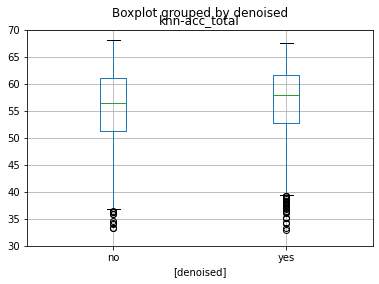

In [27]:
param = 'denoised'
print(param)
outvar="knn-acc_total"

df = eval_table
boxplot = df[[param]+[outvar]].boxplot(by=param)
plt.ylim(30,70)

In [32]:
print(np.min(eval_table.S_total))
print(np.max(eval_table.S_total))
print(np.min(eval_table.SIL_total))
print(np.max(eval_table.SIL_total))
print(np.min(eval_table.knncc_total))
print(np.max(eval_table.knncc_total))

31.73234531400153
66.38407436981849
-0.2711728701677728
0.2385007264126795
10.161867080076274
42.479727796987866


In [28]:
y_lower_dict = {"SIL":-0.65,
                "SIL_total": -0.3,
                "S":0,
                "S_total": 30,
                "knncc":0,
                "knncc_total": 10,
                "knn-acc": 0,
                "knn-acc_total": 30}
y_upper_dict = {"SIL":0.65,
                "SIL_total": 0.3,
                "S":100,
                "S_total": 70,
                "knncc":100,
                "knncc_total": 45,
                "knn-acc": 100,
                "knn-acc_total": 70}

In [40]:
# BOXPLOTS

for outvar in ['S_total', 'SIL_total']:
    for param in params[:-1]:
        other_params = set(params).difference([param, 'n_repeat'])
        boxplot = df[[param]+[outvar]].boxplot(by=param)

        plt.ylim(y_lower_dict[outvar], y_upper_dict[outvar])
        plt.suptitle('')
        plt.title('')
        plt.xlabel(param)
             
        plt.savefig(os.path.join(os.path.sep, FIGURES,'box_'+outvar+'_'+param+'.jpg'))
        plt.close()

In [43]:
# LINE PLOTS

for out_v in ["SIL", "S", "knncc"]:
    outvars = [out_v+'_'+x for x in calltypes]
    #outvars = [out_v+'_total']+outvars
    
    for param in params[:-1]:
        other_params = set(params).difference([param, 'n_repeat'])

        df = eval_table

        #print(df.shape)
        means = df[[param, out_v+'_total']]
        df = df[[param]+outvars]

        melted = pd.melt(df, id_vars=param, value_vars=outvars)
        melted = melted.sort_values(by=param)

        sns.lineplot(x=param, y="value", hue="variable", data=melted, palette="Set2", hue_order=outvars, err_style='band')
        sns.lineplot(x=param, y=out_v+'_total', data=means, color='black')
        plt.ylabel(out_v)
        plt.ylim(y_lower_dict[out_v], y_upper_dict[out_v])
        
        lg = plt.legend(bbox_to_anchor=(1.05,1),loc=2, borderaxespad=0.)
        plt.savefig(os.path.join(os.path.sep, FIGURES,'line_'+out_v+'_'+param+'.jpg'), bbox_extra_artists=(lg,), bbox_inches='tight')
        plt.close()

In [44]:
# Lineplots with error bars

for out_v in ["SIL", "S", "knncc"]:
    outvars = [out_v+'_'+x for x in calltypes]
    color_dict = dict(zip(outvars, pal))

    for param in params[:-1]:
        other_params = set(params).difference([param, 'n_repeat'])

        df = eval_table
        #print(df.shape)
        means = df[[param, out_v+'_total']]
        df = df[[param]+outvars]
        
        levels = sorted(list(set(df[param])))
        mean_df = df.groupby([param]).mean()
        std_df = df.groupby([param]).std()

        fig, ax = plt.subplots(figsize=(7, 4))

        for outvar in outvars:
            y = mean_df[outvar].values
            yerr = std_df[outvar].values
            ax.errorbar(levels, y, yerr=yerr,color=color_dict[outvar]) # linestype=ls

        ax.set_ylim(y_lower_dict[out_v], y_upper_dict[out_v])
        ax.set_title(param)
        plt.savefig(os.path.join(os.path.sep, FIGURES,'err_'+out_v+'_'+param+'.jpg'))
        plt.close()

In [45]:
# Lineplots with error bars with Mean (?)

for out_v in ["SIL", "S", "knncc"]:
#for out_v in ["S"]:
    outvars = [out_v+'_'+x for x in calltypes]
    color_dict = dict(zip(outvars, pal))
    
    outvars = [out_v+'_total']+outvars
    color_dict[out_v+'_total'] = "black"
    #for param in params[0:2]:
    for param in params[:-1]:
        other_params = set(params).difference([param, 'n_repeat'])

        df = eval_table
        #print(df.shape)
        means = df[[param, out_v+'_total']]
        df = df[[param]+outvars]
        
        levels = sorted(list(set(df[param])))
        mean_df = df.groupby([param]).mean()
        std_df = df.groupby([param]).std()

        fig, ax = plt.subplots(figsize=(7, 4))

        for outvar in outvars:
            y = mean_df[outvar].values
            yerr = std_df[outvar].values
            ax.errorbar(levels, y, yerr=yerr,color=color_dict[outvar]) # linestype=ls

        ax.set_ylim(y_lower_dict[out_v], y_upper_dict[out_v])
        ax.set_title(param)
        plt.savefig(os.path.join(os.path.sep, FIGURES,'errmean_'+out_v+'_'+param+'.jpg'))
        plt.close()

In [ ]:
#df = df.groupby([param]).mean()

In [269]:
eval_table.head(5)

,preprocess_type,metric_type,duration_method,min_dist,spread,n_neighbors,n_comps,input_type,denoised,n_mels,...,SIL_sn,SIL_soc,knncc_agg,knncc_al,knncc_cc,knncc_ld,knncc_mo,knncc_sn,knncc_soc,knncc_total
0,no,euclidean,pad,0.0,1.0,15,5,melspecs,no,40,...,0.394241,-0.415412,4.266667,35.448916,19.566689,0.0,15.415020,79.083558,23.223570,25.286346
1,no,euclidean,pad,0.0,1.0,15,5,melspecs,no,40,...,0.399913,-0.419289,3.466667,36.687307,22.613406,0.0,16.732543,79.838275,22.963605,26.043114
2,no,euclidean,pad,0.0,1.0,15,5,melspecs,no,40,...,0.389978,-0.408692,6.933333,35.139319,20.379147,0.0,12.516469,77.088949,21.923744,24.854423
3,no,euclidean,pad,0.0,1.0,15,5,melspecs,no,40,...,0.396846,-0.416409,5.066667,35.913313,19.702099,0.0,13.570487,77.735849,22.530329,24.931249
4,no,euclidean,pad,0.0,1.0,15,5,melspecs,no,40,...,0.396419,-0.413416,4.800000,35.603715,22.410291,0.0,16.864295,78.921833,22.357019,25.851022


In [33]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [34]:
print(np.min(eval_table.S_total))
print(np.max(eval_table.S_total))

31.73234531400153
66.38407436981849


In [29]:
plot_params = ['preprocess_type',
               'metric_type',                          
               'duration_method',
               'denoised',              
               'n_mels',
               'f_unit',
               'bp_filtered']

In [36]:
outvar = 'S_total'

for i, param in enumerate(plot_params):
    print(param)
    other_params = set(params).difference([param, 'n_repeat'])
    df = eval_table
    #for p in other_params:
    #    df = df.loc[df[p]==p_default[p],:]
        
    levels = sorted(list(set(df[param])))
    print(levels)
    # STATS
    mod = ols(outvar+'~'+param, data=df).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print(aov_table)
    #print(mod.summary())

preprocess_type
['no', 'zs', 'zs-fl-ce']
                        sum_sq      df           F        PR(>F)
preprocess_type    9682.303413     2.0  161.443067  9.403304e-68
Residual         103544.222716  3453.0         NaN           NaN
metric_type
['correlation', 'cosine', 'euclidean', 'manhattan']
                    sum_sq      df          F        PR(>F)
metric_type    1904.105419     3.0  19.681486  1.197263e-12
Residual     111322.420710  3452.0        NaN           NaN
duration_method
['overlap', 'pad', 'pw-pad', 'stretched', 'tshift-overlap', 'tshift-pad']
                        sum_sq      df          F        PR(>F)
duration_method    3908.982956     5.0  24.673059  1.694735e-24
Residual         109317.543173  3450.0        NaN           NaN
denoised
['no', 'yes']
                 sum_sq      df          F    PR(>F)
denoised     419.598082     1.0  12.847542  0.000343
Residual  112806.928047  3454.0        NaN       NaN
n_mels
[0, 10, 20, 30, 40, 50]
                 sum_sq  

# S_total and SIL_total

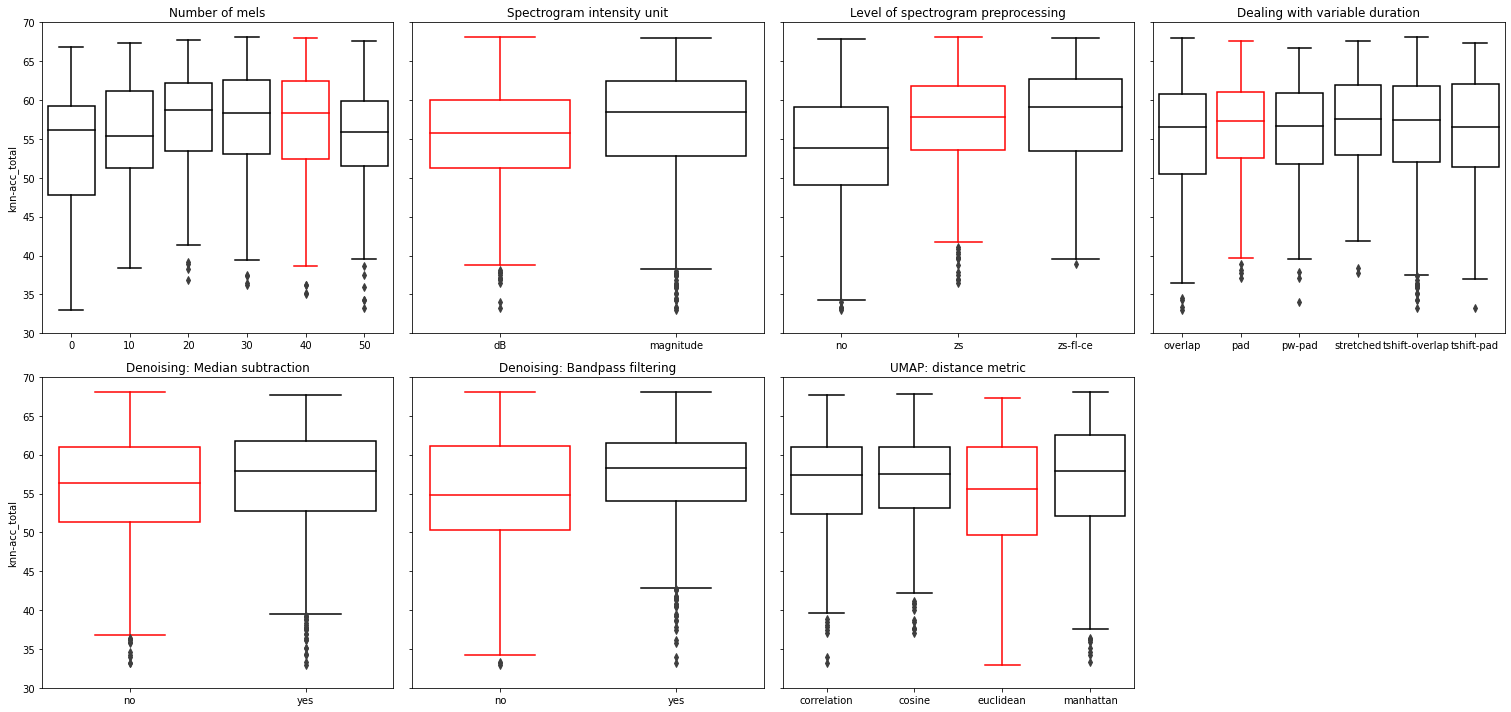

In [30]:
# BOXPLOTS
plot_params = ['n_mels',
               'f_unit',
               'preprocess_type',                        
               'duration_method',
               'denoised',               
               'bp_filtered',
               'metric_type']

title_dict = dict(zip(plot_params, ['Number of mels', 
                                    'Spectrogram intensity unit',
                                    'Level of spectrogram preprocessing',                                                                     
                                    'Dealing with variable duration', 
                                    'Denoising: Median subtraction',                                   
                                    'Denoising: Bandpass filtering',
                                    'UMAP: distance metric' 
                                   ]))
n_rows = 2
n_cols = 4

cs = list(range(0,n_cols)) * n_rows
rs_list = [[x]*n_cols for x in list(range(0,n_rows))]
rs = list()
for x in rs_list:
    for y in x:
        rs.append(y)



#fig.suptitle('Effect of different run parameters')
#for outvar in ['knn-acc_total']:
for outvar in ['S_total', 'SIL_total', 'knncc_total', 'knn-acc_total']:
#for outvar in ['S_total']:
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(21, 10), sharey=True)
    for i,param in enumerate(plot_params):
        #print(param)
        other_params = set(params).difference([param, 'n_repeat'])
        
        df = eval_table
        #for p in other_params:
        #    df = df.loc[df[p]==p_default[p],:]
        #print(df.shape)
        #print(levels)
        
        levels = sorted(list(set(df[param])))
        #color_dict = {level: "red" if level == p_default[param] else "white" for level in levels}
        
        ax = sns.boxplot(ax=axes[rs[i], cs[i]], data=df, x=param, y=outvar, order=levels)#, palette = color_dict)
        
        for b,box in enumerate(ax.artists):
            if b==levels.index(p_default[param]):
                col = "red"
            else:
                col="black"
            box.set_edgecolor(col)
            box.set_facecolor("white")#

        # iterate over whiskers and median lines
            for j in range(6*b,6*(b+1)):
                ax.lines[j].set_color(col)
            
            
        ax.set_ylim(y_lower_dict[outvar], y_upper_dict[outvar])
        ax.set_title(title_dict[param])
        ax.set_xlabel('')
        ax.set_ylabel('')

    plt.tight_layout()
    plt.setp(axes[:, 0], ylabel=outvar)
    fig.delaxes(ax= axes[1,3]) 
    #fig.delaxes(ax= axes[2,3]) 
    plt.savefig(os.path.join(os.path.sep, FIGURES,'box_'+outvar+'_all.jpg'), bbox_inches='tight')
    #plt.close()